In [1]:
import uproot
import pandas as pd
import sys,os, time, glob, re  
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from tqdm.auto import tqdm       
tqdm.pandas()

# import the custom python module
import muonfixedid, chamberlist_run3   
import splitter_regions_Run2
import mdtCalib_functions

inputCalibNtuple='data23_calib.00456729.calibration_MuonAll.daq.RAW.0000_0004-0120.ntuple.root'
f=uproot.open(inputCalibNtuple)  

tree=f['Segments']                                     
run = inputCalibNtuple.split('0',1)[1][:6]        
region = int(inputCalibNtuple.split("-", 1)[1][:4])
lb = inputCalibNtuple.split("-", 1)[0][-9:]          
branchList=tree.keys()                                  
branchPrefix=['trk', 'trkHit', 'event', 'rawMdt']       
branchMapping={key : [] for key in branchPrefix}          # branchMapping is a dictionary

for branch in branchList:
    branchName, variableName= branch.split('_', 1)
    if branchName in branchPrefix:
        branchMapping[branchName].append(branch)
        
# convert mdtCalname to mdtHardname by chamberlist.py
chamberInRegion = [chamberlist_run3.MDThardname(chamberlist_run3.MDTindex(x)) for x in splitter_regions_Run2.regionlist[region]]
print('process run %s lumiblock %s region %s, chamberList %s' % (run, lb, region, chamberInRegion))

process run 045672 lumiblock 0000_0004 region 120, chamberList ['IsWRONG', 'BIS7A16', 'EES1A16', 'EES2A16', 'EMS4A16', 'EMS5A16']


In [3]:
import awkward as ak  
df_raw=ak.to_dataframe(tree.arrays(branchMapping['rawMdt']))  #converted awkwad array to dataframe df_raw

# expand all raw and trk hits with correct chamberName and tubeInfo
df_raw['rawMdt_tubeInfo'] = df_raw['rawMdt_id'].apply(lambda x : chamberlist_run3.MDTtubename(int(x)))
df_raw['rawMdt_station'] = df_raw['rawMdt_tubeInfo'].apply(lambda x :x[:7])
df_raw['rawMdt_type'] = df_raw['rawMdt_tubeInfo'].apply(lambda x :x[:3])
print(df_raw.head(5))

df_all = tree.arrays() #gives total numner of events and not hits
total_evts=len(df_all)

print(f'Total Event in this file is {total_evts}')

                rawMdt_adc  rawMdt_gPosX  rawMdt_gPosY  rawMdt_gPosZ  \
entry subentry                                                         
0     0                 99   4114.294922  -1704.196777   9544.875000   
      1                111   4114.294922  -1704.196777   9454.769531   
      2                148   4114.294922  -1704.196777   9424.735352   
      3                198   4114.294922  -1704.196777   9094.349609   
      4                 92   4090.263916  -1694.242798   9469.787109   

                rawMdt_id  rawMdt_nRMdt  rawMdt_tdc rawMdt_tubeInfo  \
entry subentry                                                        
0     0         105446809            45        1055  BEE1A16-1-4-26   
      1         105446806            45        1172  BEE1A16-1-4-23   
      2         105446805            45         489  BEE1A16-1-4-22   
      3         105446794            45         724  BEE1A16-1-4-11   
      4         105446678            45        1207  BEE1A16-1-3-23  

# Tube_index and noise_rate dataframe

In [4]:
#tube_id gives the tube index
def tube_id(row, chamber): 
    # Grab the tube name
    x = row[0]
    # Split into components that were separated by a '-'
    ml_index=int(x.split('-')[1])
    ly_index =int(x.split('-')[2])
    tube_no =int(x.split('-')[3])

    # Calculate unique tube id 
    return (ml_index-1)*chamberlist_run3.MDTnTml(chamber,1) + (ly_index-1)*chamberlist_run3.MDTnTly(chamber,ml_index) + tube_no

act_time_window=1.3*(10**(-6))
total_evts  

#Noise rate
def noise_rate(df, chamber):
    df_raw_chamber = df[df['rawMdt_station']==chamber]

    # Aggregate tube hits with pandas value_counts() method
    tube_hits=df_raw_chamber.rawMdt_tubeInfo.value_counts()

    # Recalculate all noise_rates and construct them into a new Series
    noise_rate=tube_hits/(act_time_window*total_evts)
    
    # Convert to dataframe
    noise_rate_df = noise_rate.reset_index()
    
    # Add column names to two columns
    noise_rate_df.columns = ['Tube_Name', 'Noise_Rate']
    
    # Create new column for tube ids and calculate each id inline in the tube_id() function
    noise_rate_df['Tube_ID'] = noise_rate_df.apply(lambda row: tube_id(row, chamber), axis=1)
    
    return noise_rate_df #returns a dataframe
    
df_noise_rate=noise_rate(df_raw,'BIS7A16')
df_noise_rate

/var/folders/w3/c0s4x6mj0rd2h643_w1y144r0000gn/T/ipykernel_9375/1054391261.py:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x = row[0]


,Tube_Name,Noise_Rate,Tube_ID
0,BIS7A16-2-4-49,493554.980179,601
1,BIS7A16-2-4-16,299167.309498,568
2,BIS7A16-2-4-15,246987.235808,567
3,BIS7A16-2-4-84,238713.932476,636
4,BIS7A16-2-4-83,202427.923214,635
...,...,...,...
642,BIS7A16-2-2-92,1281.779389,452
643,BIS7A16-2-1-12,186.440638,276
644,BIS7A16-2-1-11,116.525399,275
645,BIS7A16-2-4-1,93.220319,553


In [8]:
#Introduce adc_cut
def adc_cut(df,chamber,cut):  #returns complete dataframe just introducing adc_cut(doesn't give any info on noise_rate etc)

    df_raw_chamber = df[df['rawMdt_station']==chamber]
    df_raw_adc=df_raw_chamber[df_raw_chamber['rawMdt_adc']>cut]
    return df_raw_adc   


In [12]:
#Extract list of noisy_tubes and dataframe removing noisy_tubes
def noise_tubes(df,chamber,cut,noise_thresh):

    
    # adc_cut=50
    
    # df_raw_chamber = df[df['rawMdt_station']==chamber]
    # df_raw_adc_cut=df_raw_chamber[df_raw_chamber['rawMdt_adc']>adc_cut]   #Complete dataframe after introducing adc_cut
    df_raw_adc_cut=adc_cut(df_raw,'BIS7A16',cut)  
    df_noise_adc=noise_rate(df_raw_adc_cut,'BIS7A16')    #creating a separate dataframe for noise_ate and tube_id from after adc_cut df
    noisy_tubes=df_noise_adc[df_noise_adc['Noise_Rate']>noise_thresh]  #Extract all the rows for noise_rate>20k from the df_noise_rate dataframe
    noisy_list=noisy_tubes['Tube_Name']      #extract names for all the noisy tubes extracted above
    print('List of noisy_tubes for chamber %s'%(chamber),noisy_list)

def df_filtered(df,chamber,cut,noise_thresh):

    df_raw_chamber = df[df['rawMdt_station']==chamber]
    df_raw_adc_cut=df_raw_chamber[df_raw_chamber['rawMdt_adc']>cut]
    # df_raw_adc_cut=adc_cut(df_raw,'BIS7A16')  #Complete dataframe after introducing adc_cut
    df_noise_adc=noise_rate(df_raw_adc_cut,'BIS7A16')    #creating a separate dataframe for noise_ate and tube_id from after adc_cut df
    noisy_tubes=df_noise_adc[df_noise_adc['Noise_Rate']>noise_thresh]  
#make a dataframe excluding noisy tubes
    df_raw_chamber_noisy_filtered=df_raw_adc_cut[~df_raw_adc_cut['rawMdt_tubeInfo'].isin(noisy_tubes['Tube_Name'])]
    return df_raw_chamber_noisy_filtered
    
ADC_CUT_VAL = 50  
noise_thresh=20000
df_filtered(df_raw,'BIS7A16',ADC_CUT_VAL,noise_thresh)

# noise_tubes(df_raw,'BIS7A16',ADC_CUT_VAL)





/var/folders/w3/c0s4x6mj0rd2h643_w1y144r0000gn/T/ipykernel_9375/1054391261.py:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x = row[0]


rawMdt_adc  rawMdt_gPosX  rawMdt_gPosY  rawMdt_gPosZ  \
entry subentry                                                         
1     0                242   4313.193848  -1786.583252   7326.850098   
      12               128   4301.101074  -1781.574341   6972.000000   
3     4                141   4313.193848  -1786.583252   6843.649902   
      5                146   4313.193848  -1786.583252   6828.549805   
      7                 96   4301.101074  -1781.574341   6805.899902   
...                    ...           ...           ...           ...   
33004 14               136   4222.755859  -1749.122803   6383.100098   
      15               121   4222.755859  -1749.122803   6352.899902   
      16               164   4222.755859  -1749.122803   6050.899902   
      17               174   4210.663086  -1744.113892   6375.549805   
33005 14               146   4222.755859  -1749.122803   6186.799805   

                rawMdt_id  rawMdt_nRMdt  rawMdt_tdc rawMdt_tubeInfo  \
entry subentry                                                        
1     0          24707037           101         712  BIS7A16-2-4-94   
      12         24706886           101         189  BIS7A16-2-3-71   
3     4          24707005           194         298  BIS7A16-2-4-62   
      5          24707004           194         119  BIS7A16-2-4-61   
      7          24706875           194         133  BIS7A16-2-3-60   
...                   ...           ...         ...             ...   
33004 14         24706335           117         302  BIS7A16-1-3-32   
      15         24706333           117         402  BIS7A16-1-3-30   
      16         24706313           117         183  BIS7A16-1-3-10   
      17         24706206           117         341  BIS7A16-1-2-31   
33005 14         24706322           146         298  BIS7A16-1-3-19   

               rawMdt_station rawMdt_type  
entry subentry                             
1     0               BIS7A16         BIS  
      12              BIS7A16         BIS  
3     4               BIS7A16         BIS  
      5               BIS7A16         BIS  
      7               BIS7A16         BIS  
...                       ...         ...  
33004 14              BIS7A16         BIS  
      15              BIS7A16         BIS  
      16              BIS7A16         BIS  
      17              BIS7A16         BIS  
33005 14              BIS7A16         BIS  

[116797 rows x 10 columns]

/var/folders/w3/c0s4x6mj0rd2h643_w1y144r0000gn/T/ipykernel_9375/1054391261.py:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x = row[0]
/var/folders/w3/c0s4x6mj0rd2h643_w1y144r0000gn/T/ipykernel_9375/1054391261.py:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x = row[0]
/var/folders/w3/c0s4x6mj0rd2h643_w1y144r0000gn/T/ipykernel_9375/1054391261.py:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x = row[0]
/var/folders/w3/c0s4x6

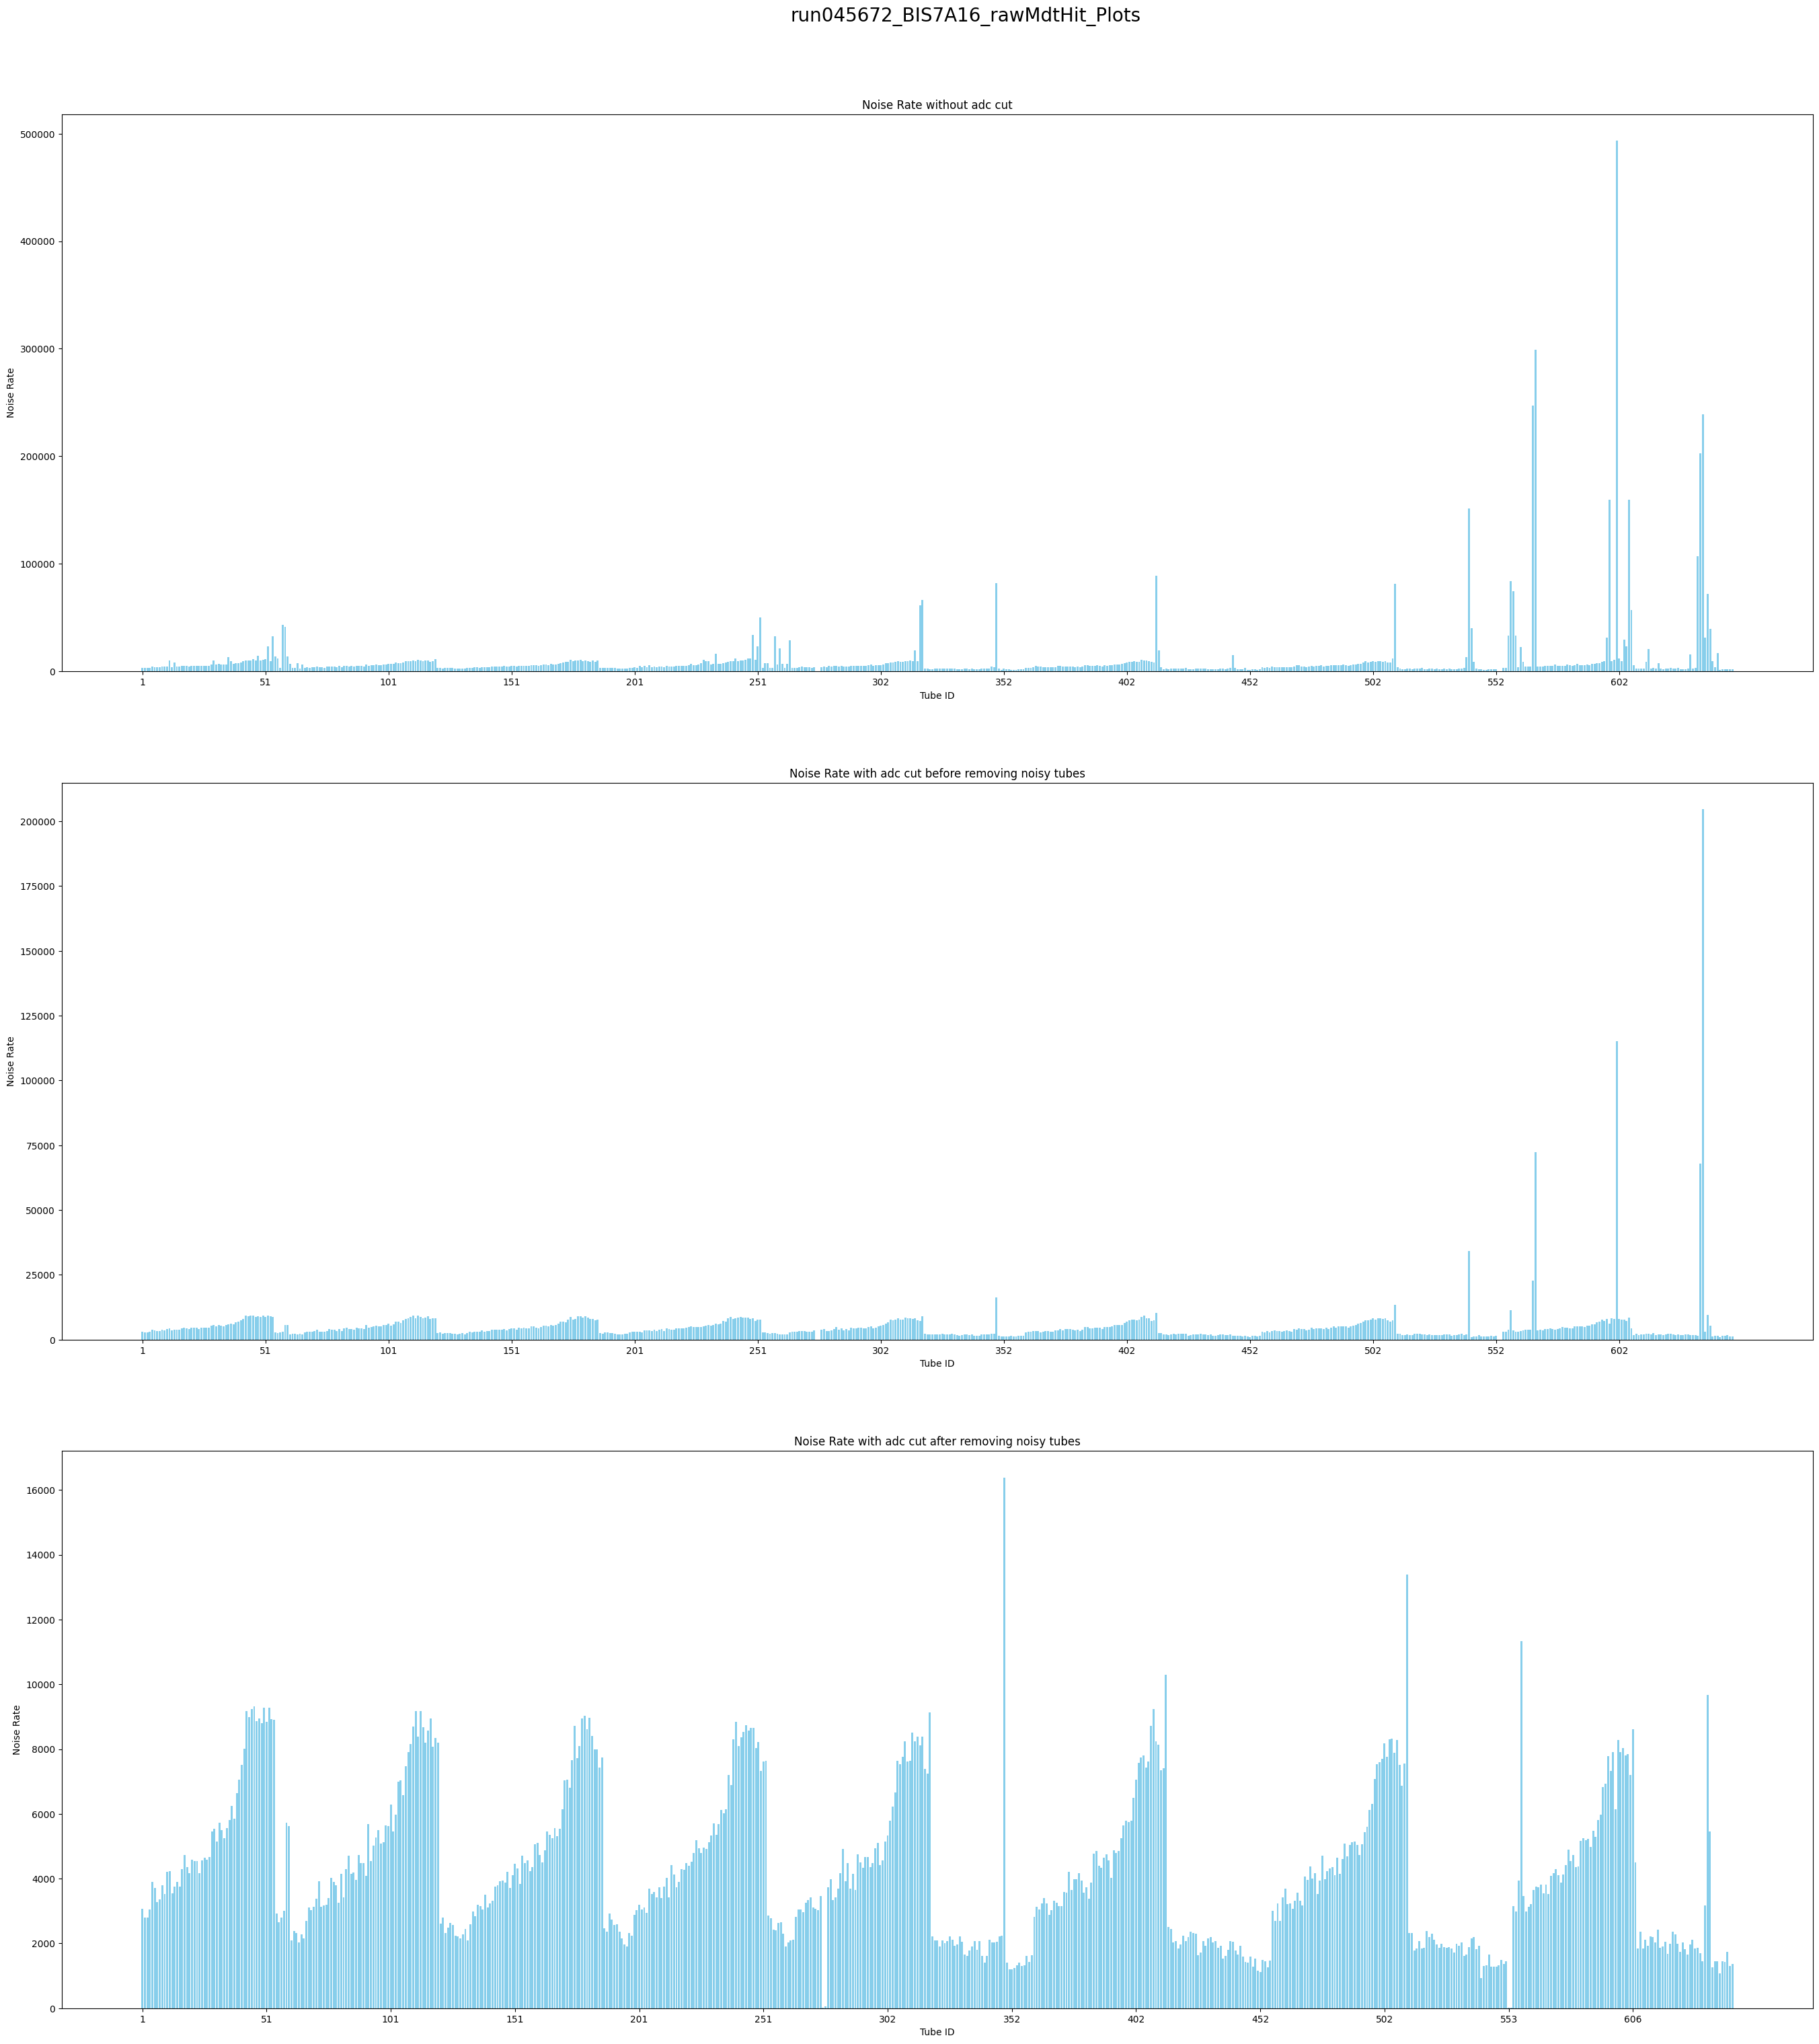

In [15]:
#Noise_Rate v/s Tube_Id Plot
def plot_for_noise_rate(df, chamber, cut,noise_thresh):
    
    df_raw_chamber = df[df['rawMdt_station']==chamber]

    run='456729'
    fig,axes = plt.subplots(figsize=(28, 32), nrows = 3, ncols = 1)  
    fig.subplots_adjust(top = 0.93, bottom = 0.05, left =0.02,right =0.95, wspace = 0.2, hspace = 0.2)
    fig.suptitle('run%s_%s_rawMdtHit_Plots'%(run,chamber), fontsize=20)
    alpha_value = 1  #Transparency
    
    df_noise_rate=noise_rate(df_raw_chamber,'BIS7A16')
    df_noise_rate_sorted=df_noise_rate.sort_values(by='Tube_ID', ascending=True)
    
    axes[0].bar(df_noise_rate_sorted['Tube_ID'].astype(str), df_noise_rate_sorted['Noise_Rate'], color='skyblue')
    axes[0].set_title('Noise Rate without adc cut')
    axes[0].set_xlabel('Tube ID')
    axes[0].set_ylabel('Noise Rate')
    axes[0].set_xticks(np.arange(0, len(df_noise_rate_sorted['Tube_ID'])+1, 50))
    
#Noise_rate Dataframe with adc_cut
    df_raw_chamber_with_adc_cut=adc_cut(df,chamber,cut)
    df_noise_rate_with_adc_cut = noise_rate(df_raw_chamber_with_adc_cut,'BIS7A16')
    df_noise_rate_with_adc_cut_sorted = df_noise_rate_with_adc_cut.sort_values(by='Tube_ID', ascending=True) 


    axes[1].bar(df_noise_rate_with_adc_cut_sorted['Tube_ID'].astype(str), df_noise_rate_with_adc_cut_sorted['Noise_Rate'], color='skyblue')
    axes[1].set_title('Noise Rate with adc cut before removing noisy tubes')
    axes[1].set_xlabel('Tube ID')
    axes[1].set_ylabel('Noise Rate')
    axes[1].set_xticks(np.arange(0, len(df_noise_rate_with_adc_cut_sorted['Tube_ID'])+1, 50))
    
#Noise_rate Dataframe with adc_cut and noisy tubes removed
    df_raw_filtered=df_filtered(df,chamber,cut,noise_thresh)
    df_noise_rate_removed=noise_rate(df_raw_filtered,chamber)
    df_noise_rate_removed_sorted=df_noise_rate_removed.sort_values(by='Tube_ID', ascending=True) 
    
    axes[2].bar(df_noise_rate_removed_sorted['Tube_ID'].astype(str), df_noise_rate_removed_sorted['Noise_Rate'], color='skyblue')
    axes[2].set_title('Noise Rate with adc cut after removing noisy tubes')
    axes[2].set_xlabel('Tube ID')
    axes[2].set_ylabel('Noise Rate')
    axes[2].set_xticks(np.arange(0, len(df_noise_rate_removed_sorted['Tube_ID'])+1, 50))

    plt.show()

plot_for_noise_rate(df_raw,'BIS7A16',ADC_CUT_VAL,noise_thresh)



KeyError: 0      601
1      568
2      567
3      636
4      635
      ... 
642    452
643    276
644    275
645    553
646    554
Name: Tube_ID, Length: 647, dtype: int64

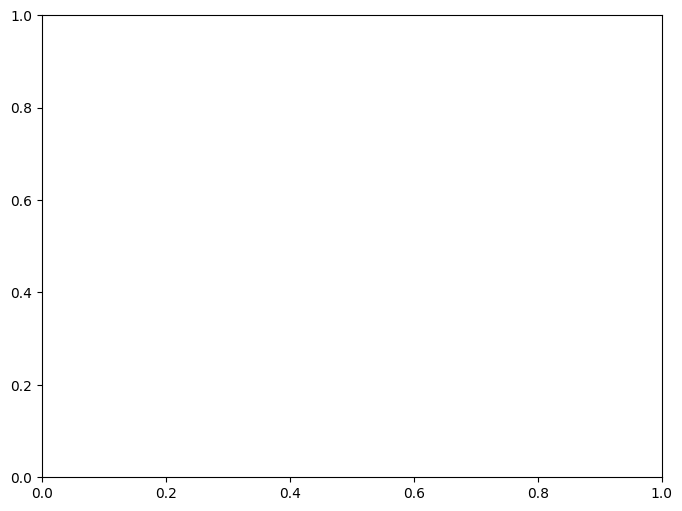

In [20]:
def noise_rate_plot(df):
    fig,ax=plt.subplots(figsize=(8,6))
    df_sorted=df.sort_values(by=df['Tube_ID'], ascending=True)
    ax.bar(df['Tube_ID'].astype(str),df_sorted['Noise_Rate'])
    ax.set_title('Noise Rate vs Tube Id')
    ax.set_xticks(np.arange(0,len(df_sorted.Tube_ID)+1,50))
    plt.show()
noise_rate_plot(df_noise_rate)

## Plot after adc cut

# Trials

# Hitmap plots

/var/folders/w3/c0s4x6mj0rd2h643_w1y144r0000gn/T/ipykernel_9375/1054391261.py:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x = row[0]


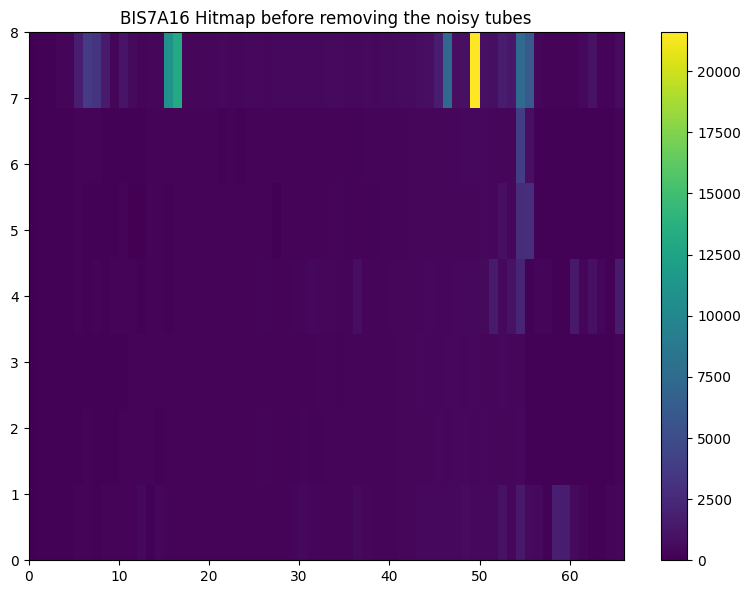

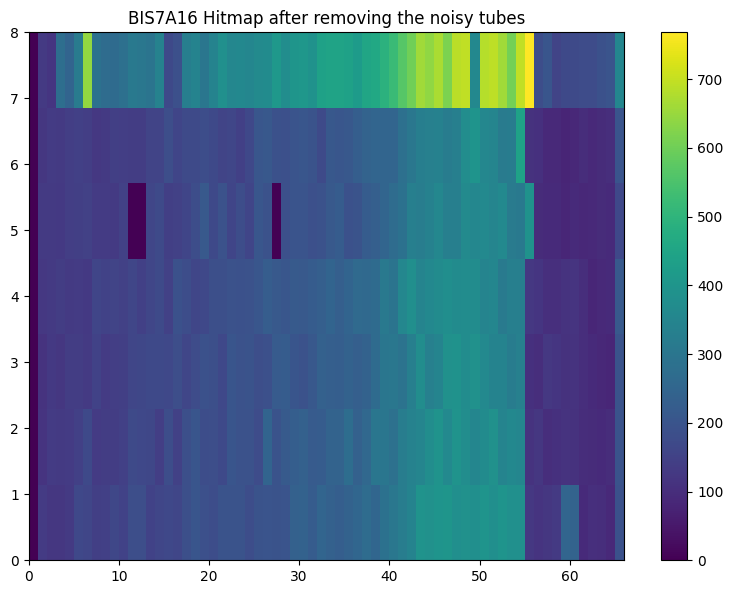

In [42]:
# plotting function for chamber hitMap and noise_hits  
def plotHitMap(df,chamber,plot_title):
    
    
    chamberinfo = list(df.rawMdt_tubeInfo)
    #apply to ML-Layer-Tube columns
    ml =[int(x.split('-')[1]) for x in chamberinfo]
    ly =[int(x.split('-')[2]) for x in chamberinfo]
    nLayer = [(int(x.split('-')[1])-1)*4 + int(x.split('-')[2]) for x in chamberinfo]
    tb =[int(x.split('-')[3]) for x in chamberinfo]

    fig,ax = plt.subplots(figsize=(8,6))
    fig.subplots_adjust(top = 0.93, bottom = 0.05, left =0.02,right =0.95, wspace = 0.2, hspace = 0.2)
    ax.set_title(plot_title)
    
    
    # get Maxtube per layer and total layer from chamberlist_run3.py
    maxLy = chamberlist_run3.MDTtotalLayers(chamber)
    maxTb = chamberlist_run3.MDTtotalTubes(chamber)
    
    counts, xedges, yedges, im = ax.hist2d(tb,nLayer, bins = [66,7], range= [[0,66],[0,8]], cmap=plt.cm.viridis,label='hitMap')
    fig.colorbar(im, ax=ax)
    plt.show()
    fig.savefig('hitMap.png')

CHAMBER_NAME='BIS7A16'
df_raw_chamber_by_rawMdtStation = df_raw[df_raw['rawMdt_station']==CHAMBER_NAME]

df_raw_chamber_filtered = df_filtered(df_raw,CHAMBER_NAME,ADC_CUT_VAL,noise_thresh)
plotHitMap(df_raw_chamber_by_rawMdtStation,CHAMBER_NAME,f"{CHAMBER_NAME} Hitmap before removing the noisy tubes")  #crude plot
plotHitMap(df_raw_chamber_filtered,CHAMBER_NAME,f"{CHAMBER_NAME} Hitmap after removing the noisy tubes") #filtered plot

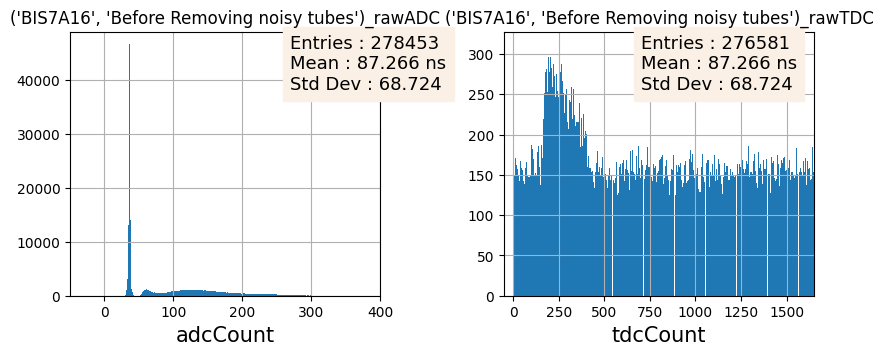

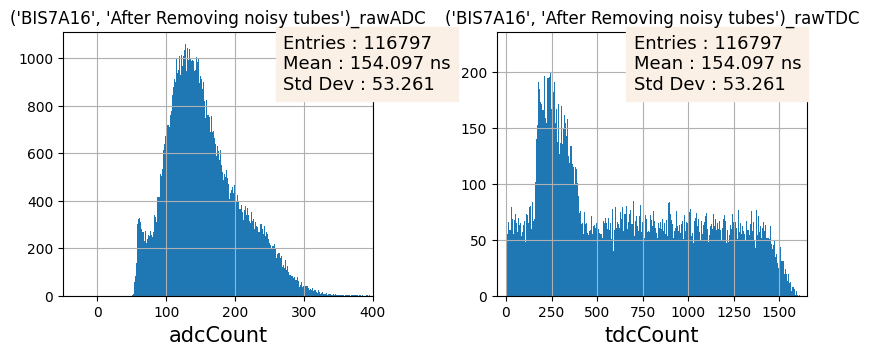

In [41]:
# raw ADC and TDC hits plot with ADC cut at 50
def plotRawMdtHits(df,chamber,title):

    fig,axes = plt.subplots(figsize=(8, 3), nrows = 1, ncols = 2)
    # fig,ax = plt.subplots(figsize=(8,6))
    fig.subplots_adjust(top = 0.93, bottom = 0.05, left =0.02,right =0.95, wspace = 0.4, hspace = 0.4)
    # fig.set_title(title, fontsize=20)
       
    # ADC count without cut
    mdt_adc = df.rawMdt_adc.values.astype(float)
    min_adc = -50
    max_adc = 400
    
    xadc, xbins, patch = axes[0].hist(mdt_adc,bins=max_adc-min_adc,range=[min_adc,max_adc],label = 'adc')
    mean = np.average(mdt_adc)
    std = np.sqrt(np.average((mdt_adc - mean)**2))
    axes[0].set_xlim(min_adc,max_adc)
    axes[0].set_xlabel('adcCount',fontsize=15)
    axes[0].text(270,np.max(xadc)*0.82,'Entries : %d\nMean : %.3f ns\nStd Dev : %.3f'%(np.sum(xadc),mean,std),backgroundcolor='linen',fontsize =13)
    axes[0].grid()
    axes[0].set_title(f'{chamber,title}_rawADC')
    
    
    # # raw TDC spectrum
    mdt_tdc = df.rawMdt_tdc.values.astype(float)
    min_tdc = -50
    max_tdc = 1650
    xtdc, xbins, patch = axes[1].hist(mdt_tdc,bins= max_tdc-min_tdc,range=[min_tdc,max_tdc],label = 'tdc')
    axes[1].set_xlim(min_tdc,max_tdc)
    axes[1].set_xlabel('tdcCount',fontsize=15)
    axes[1].text(700,np.max(xtdc)*0.82,'Entries : %d\nMean : %.3f ns\nStd Dev : %.3f'%(np.sum(xtdc),mean,std),backgroundcolor='linen',fontsize =13)
    axes[1].grid()
    axes[1].set_title(f'{chamber,title}_rawTDC')
    
    fig.patch.set_facecolor('white')
    fig.savefig('PlotAdcTdc.png')
    plt.show()
    
# plotRawMdtHits(df_raw,'BIS7A16')
plotRawMdtHits(df_raw_chamber_by_rawMdtStation,CHAMBER_NAME,'Before Removing noisy tubes')  #crude plot
plotRawMdtHits(df_raw_chamber_filtered,CHAMBER_NAME,'After Removing noisy tubes') #filtered plot

